In [2]:
import gdown
import pandas as pd

file_id = "1aR2vIofccm6zuJgQeZ206ra60IAVCPtG"
url = f"https://drive.google.com/uc?id={file_id}"

output = "preprocessed_credit_data.csv"
gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

print(data.head())
print(data.shape)

Downloading...
From: https://drive.google.com/uc?id=1aR2vIofccm6zuJgQeZ206ra60IAVCPtG
To: /content/preprocessed_credit_data.csv
100%|██████████| 59.3M/59.3M [00:00<00:00, 95.2MB/s]


    c_id  application_hour  application_day_of_week  account_open_year  \
0  10000                 5                        6               2013   
1  10001                 4                        2               2015   
2  10002                10                        3               2020   
3  10003                 7                        5               2010   
4  10004                 1                        2               2020   

   num_login_sessions  num_customer_service_calls  has_mobile_app  \
0                  13                           2               1   
1                   6                           1               1   
2                   1                           2               1   
3                   4                           1               1   
4                   6                           2               1   

   paperless_billing  default  monthly_income  ...  loan_purpose_Other  \
0                  1        0        0.663462  ...               F

In [3]:
X = data.drop(columns=['default', 'c_id'])
y = data['default']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86     17081
           1       0.12      0.61      0.20       919

    accuracy                           0.76     18000
   macro avg       0.55      0.69      0.53     18000
weighted avg       0.93      0.76      0.82     18000

ROC AUC: 0.7646240893180091


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [9]:
model = LogisticRegression(
      max_iter=2000,        # higher iterations to ensure convergence
      solver='lbfgs',
      class_weight='balanced',
      random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     17081
           1       0.13      0.51      0.21       919

    accuracy                           0.81     18000
   macro avg       0.55      0.67      0.55     18000
weighted avg       0.93      0.81      0.85     18000

ROC AUC: 0.7486
Confusion Matrix:
[[14022  3059]
 [  447   472]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
from xgboost import XGBClassifier

In [11]:
xgb_model = XGBClassifier(
      n_estimators=500,
      max_depth=6,
      learning_rate=0.05,
      scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handles imbalance
      random_state=42,
      use_label_encoder=False,
      eval_metric='logloss')

xgb_model.fit(X_train_res, y_train_res)


y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:10:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     17081
           1       0.13      0.61      0.22       919

    accuracy                           0.78     18000
   macro avg       0.55      0.70      0.54     18000
weighted avg       0.93      0.78      0.84     18000

ROC AUC: 0.7682
Confusion Matrix:
[[13416  3665]
 [  354   565]]


In [16]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:22:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     17081
           1       0.44      0.16      0.24       919

    accuracy                           0.95     18000
   macro avg       0.70      0.58      0.60     18000
weighted avg       0.93      0.95      0.93     18000

ROC AUC: 0.8074133939937591
Confusion Matrix:
[[16887   194]
 [  769   150]]


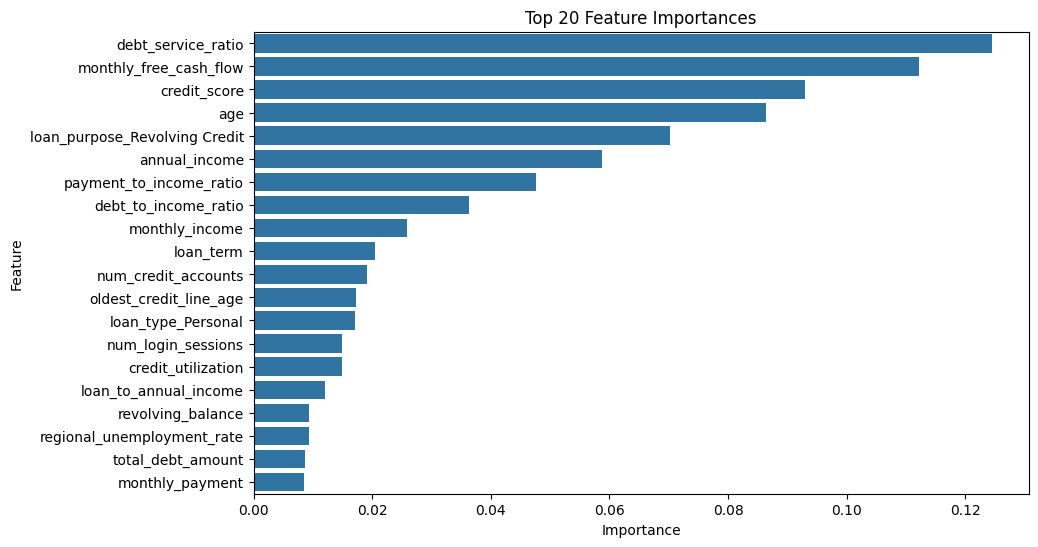

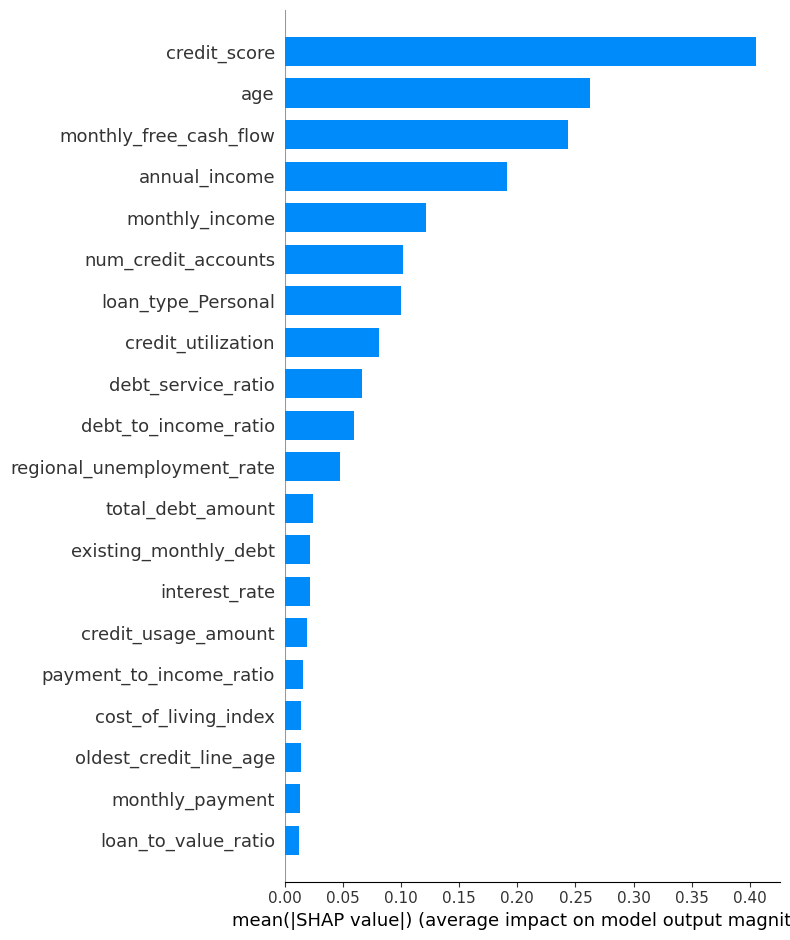

In [13]:
param_grid = {
      'n_estimators': [200, 400, 600],
      'max_depth': [3, 5, 7],
      'learning_rate': [0.01, 0.05, 0.1],
      'subsample': [0.7, 0.8, 1.0],
       'colsample_bytree': [0.7, 0.8, 1.0],
       'gamma': [0, 0.1, 0.3],
        'scale_pos_weight': [1, (len(y_train)-sum(y_train))/sum(y_train)]}

xgb_clf = xgb.XGBClassifier(
      objective='binary:logistic',
      eval_metric='auc',
      use_label_encoder=False,
     random_state=42)
search = RandomizedSearchCV(
      xgb_clf, param_distributions=param_grid,
      n_iter=20, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1, random_state=42)

search.fit(X_train, y_train)

print("Best Parameters:", search.best_params_)
best_xgb = search.best_estimator_


y_proba = best_xgb.predict_proba(X_test)[:,1]

# Threshold tuning for minority class
threshold = 0.3  # adjust if you want higher recall
y_pred = (y_proba >= threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_xgb.feature_importances_})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20))
plt.title("Top 20 Feature Importances")
plt.show()

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [14]:
from collections import Counter

counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

best_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=0.7,
    gamma=0.1,
    scale_pos_weight=scale_pos_weight,  # important for imbalanced data
    random_state=42,
    use_label_encoder=False)
best_xgb.fit(X_train, y_train)

y_proba = best_xgb.predict_proba(X_test)[:,1]

threshold = 0.2
y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:27:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.99      0.28      0.44     17081
           1       0.07      0.96      0.13       919

    accuracy                           0.32     18000
   macro avg       0.53      0.62      0.28     18000
weighted avg       0.95      0.32      0.43     18000

ROC AUC: 0.8070125961311267
Confusion Matrix:
[[ 4860 12221]
 [   37   882]]


In [15]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Probabilities for positive class
y_proba = best_xgb.predict_proba(X_test)[:,1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)

# Example: choose threshold where recall ~0.8 for defaults
import numpy as np
target_recall = 0.8
idx = np.argmin(np.abs(recall - target_recall))
optimal_threshold = pr_thresholds[idx]
print("Optimal threshold for ~80% recall:", optimal_threshold)

# Apply threshold
y_pred = (y_proba >= optimal_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Optimal threshold for ~80% recall: 0.40018877
              precision    recall  f1-score   support

           0       0.98      0.63      0.77     17081
           1       0.11      0.80      0.19       919

    accuracy                           0.64     18000
   macro avg       0.54      0.72      0.48     18000
weighted avg       0.94      0.64      0.74     18000

Confusion Matrix:
 [[10841  6240]
 [  184   735]]
ROC AUC: 0.8070125961311267


### FINAL MODEL

In [17]:
xgb_model = XGBClassifier(
      n_estimators=200,
      max_depth=3,
      learning_rate=0.05,
      subsample=1.0,
      colsample_bytree=0.7,
      gamma=0.1,
      scale_pos_weight=1,
      use_label_encoder=False,
      eval_metric='logloss',
      random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)


# 4. Predict probabilities and apply custom threshold

threshold = 0.4002  # tuned for ~80% recall
y_proba = xgb_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= threshold).astype(int)


# 5. Evaluation

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:35:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     17081
           1       0.52      0.09      0.15       919

    accuracy                           0.95     18000
   macro avg       0.74      0.54      0.56     18000
weighted avg       0.93      0.95      0.93     18000

Confusion Matrix:
 [[17005    76]
 [  837    82]]
ROC AUC: 0.8074133939937591


In [19]:
joblib.dump(xgb_model, 'final_xgb_model.pkl')

['final_xgb_model.pkl']